In [3]:
import jax.numpy as jnp
from jax import grad, jit, value_and_grad, vmap
from jax import random
from jax.lax import scan
import matplotlib.pyplot as plt
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']

c:\repos\dl_and_dynamical_systems_annsim2022\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\repos\dl_and_dynamical_systems_annsim2022\venv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\repos\dl_and_dynamical_systems_annsim2022\venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Ordinary Differential Equations in Python
The Lotka-Volterra equations is a coupled system of ODEs that can be used to model how a populations of predator and prey animals evolve in nature.

$$
f(t,y) = 
\begin{bmatrix}
\frac{\partial f}{\partial x}(z,t) \\
\frac{\partial f}{\partial y}(z,t)
\end{bmatrix}
= 
\begin{bmatrix}
ax - bxy \\
cxy - dy
\end{bmatrix}
$$

It has two states:
- x : number of prey
- y : number of predators

And four parameters
- a: growth rate of prey
- b: mortality due to predators
- c: growth rate from feeding
- d: mortality rate of predators

The derivative of the system can be defined in Python as:

In [4]:
a = 1.0
b = 1.0
d = 1.0
c = 1.0

def f(t, y, a, b, d, c):
    x, y = y
    dx = a * x - b * x * y
    dy = c * x * y - d * y
    return jnp.array((dx, dy))

f(0.0, (2.0,1.0), a,b,c,d)

DeviceArray([0., 1.], dtype=float32)

The function $f$ can be seen as a vector field over the state-space of the system.
We can plot the vector field by evaluating the derivative of the system on a grid of the state-space.

Text(0, 0.5, 'predators')

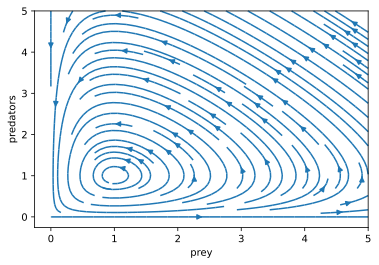

In [5]:
res = 1.0
xx, yy = jnp.meshgrid(
    jnp.arange(0.0, 5.0 + res, res),
    jnp.arange(0.0, 5.0 + res, res)
)

dx, dy = f(0.0,(xx,yy),a,b,c,d)

fig, ax = plt.subplots()
ax.streamplot(xx,yy,dx,dy)
ax.set_xlabel("prey")
ax.set_ylabel("predators")

The solution to the IVP of the ODEs is found by integrating the derivative starting from $t_0$ until $t$ and adding the initial state $y_0$:
$$y(t) = \int_{t_0}^t f(t,y) dt + y(t_0)$$

For most ODEs there does not exist a close form solution to this integral and we instead use numerical solvers to approximate the solution.
A simple example of such is the forward Euler integration scheme
$y_{k+1} = y_k + h_k f(t_k, y_k)$,

A straight forward way to implement this in Python is using a for loop and lists for storing the intermediate values.

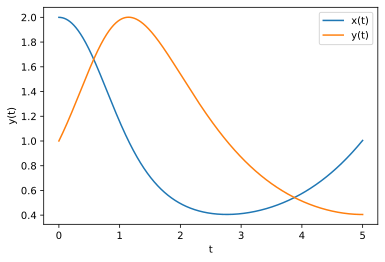

In [9]:
def solve_euler(f, t, y0, args):
    step_sizes = t[1:] - t[:-1]
    y_cur = y0
    Y = [y_cur]

    for t, step_size in zip(t[1:], step_sizes):
        dydt = f(t, y_cur, *args)
        y_new = y_cur + step_size * dydt
        Y.append(y_new)
        y_cur = y_new

    return jnp.stack(Y, axis=1)

h = 0.001
t_start = 0.0
t_end = 5.0
t = jnp.arange(t_start, t_end + h, h)
y0 = jnp.array((2.0, 1.0))

xy = solve_euler(f, t, y0, (a,b,c,d))
fig, ax = plt.subplots()
ax.plot(t,xy[0], label="x(t)")
ax.plot(t,xy[1], label="y(t)")
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend()

Jax is able to JIT compile functions with loops, however doing so requires that they are unrolled, which leads to long compilation times.
An alternative is to use the [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) operation, which allows the function to be traced much faster.
The forward Euler function can be defined using the `scan` method as follows:

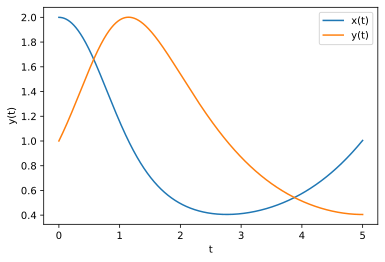

In [10]:
def solve_euler_scan(f, t, y0, args):
    step_sizes = t[1:] - t[:-1]

    def f_scan(y_cur, t_and_step):
        t, step_size = t_and_step
        dydt = f(t, y_cur, *args)
        y_new = y_cur + step_size * dydt
        return y_new, y_new

    _, Y = scan(f_scan, init=y0, xs=(t[1:], step_sizes))
    Y = jnp.concatenate((y0.reshape(-1, 1), Y.T), axis=1)
    return Y

xy = solve_euler_scan(f, t, y0, (a,b,c,d))
fig, ax = plt.subplots()
ax.plot(t,xy[0], label="x(t)")
ax.plot(t,xy[1], label="y(t)")
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend()

# Parameter estimation
Unknown parameters of the Lotka-Volterra equations can be estimated by simulating the system for a given parameter choice and using gradient descent to update the estimate such the difference between the target data and that of the model is minimized.

For simplicity we may suppose that only the parameter $a$ is unknown and that we have a rough estimate of what the value may be.

100%|██████████| 1000/1000 [00:00<00:00, 1260.59it/s]


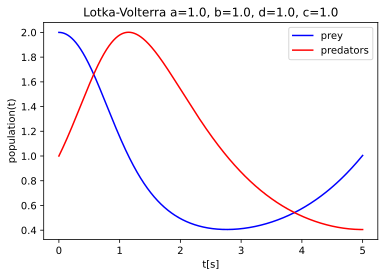

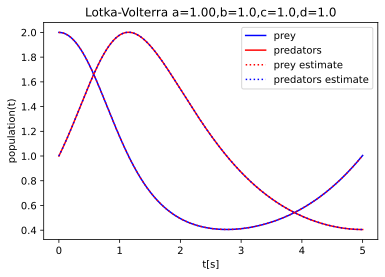

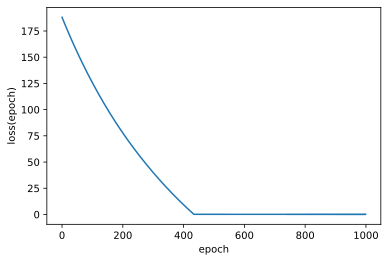

In [19]:
def loss(y_target, a):
    y_predicted = solve_euler_scan(f, t, y0, (a, b, d, c))
    return jnp.linalg.norm(y_target - y_predicted)

def update_a(y_target, t, y0, a, b, d, c):
    value, dLda = value_and_grad(loss,argnums=1)(y_target, a)
    return value, a - lr * dLda

y = solve_euler_scan(f, t, y0, (a, b, d, c))

n_epochs = 1000
a_estimate = 3.0
lr = 0.00005  # learning rate
losses = []

update_a = jit(update_a)

for _ in tqdm(range(n_epochs)):
    value, a_estimate = update_a(Y, t, y0, a_estimate, b, d, c)
    losses.append(value)

y_predicted = solve_euler_scan(f, t, y0, (a_estimate, b, d, c))

fig, ax = plt.subplots()
ax.plot(t, y[0], label="prey", color="blue")
ax.plot(t, y[1], label="predators", color="red")
ax.plot(t, y_predicted[0], label="prey estimate", color="red", linestyle="dotted")
ax.plot(
    t, y_predicted[1], label="predators estimate", color="blue", linestyle="dotted"
)
ax.set_xlabel("t[s]")
ax.set_ylabel("population(t)")
ax.legend()
ax.set_title(f"Lotka-Volterra a={a_estimate:.2f},b={b},c={c},d={d}")

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epoch")
_ = ax.set_ylabel("loss(epoch)")

100%|██████████| 100000/100000 [00:34<00:00, 2906.66it/s]


Text(0, 0.5, 'loss(epoch)')

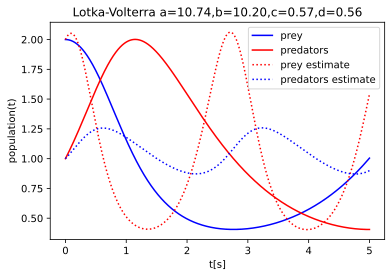

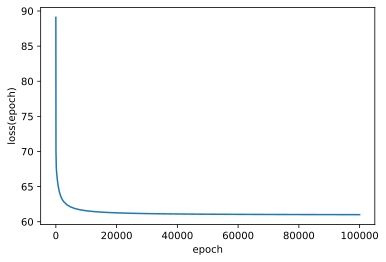

In [26]:
n_epochs = 20000
lr = 1e-3
a_estimate = 2.0
b_estimate = 1.5
c_estimate = 2.0
d_estimate = 2.0
losses = []

def update_abcd(y_target, t, y0, a, b, c, d):
    def loss(a, b, c, d):
        y_predicted = solve_euler_scan(f, t, y0, (a, b, c, d))
        return jnp.linalg.norm(y_target - y_predicted)

    loss, dL = value_and_grad(loss, argnums=(0, 1, 2, 3))(a, b, c, d)
    dLda, dLdb, dLdc, dLdd = dL
    return loss, a - lr * dLda, b - lr * dLdb, c - lr * dLdc, d - lr * dLdd



update_abcd = jit(update_abcd)

for _ in tqdm(range(n_epochs)):

    value, a_estimate, b_estimate, c_estimate, d_estimate = update_abcd(
        y, t, y0, a_estimate, b_estimate, c_estimate, d_estimate
    )
    losses.append(value)

y_predicted = solve_euler_scan(
    f, t, y0, (a_estimate, b_estimate, c_estimate, d_estimate)
)


fig, ax = plt.subplots()
ax.plot(t, y[0], label="prey", color="blue")
ax.plot(t, y[1], label="predators", color="red")
ax.plot(t, y_predicted[0], label="prey estimate", color="red", linestyle="dotted")
ax.plot(
    t, y_predicted[1], label="predators estimate", color="blue", linestyle="dotted"
)
ax.set_xlabel("t[s]")
ax.set_ylabel("population(t)")
ax.legend()
ax.set_title(
    f"Lotka-Volterra a={a_estimate:.2f},b={b_estimate:.2f},c={c_estimate:.2f},d={d_estimate:.2f}"
)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epoch")
ax.set_ylabel("loss(epoch)")


In [ ]:

def predict(params, inputs):
    for W, b in params:
        outputs = jnp.dot(inputs, W.T) + b
        inputs = jnp.tanh(outputs)
    return outputs


def initialize_mlp(sizes, key):
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]



plt.show()
